In [1]:
import os
import shutil
import pandas as pd
import holidays
from time import time
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Get data 
## Our estimated SLPs

In [33]:
estimated = pd.read_csv(os.path.join(data_path, "SLPs.csv"), index_col="time")
estimated.index = pd.to_datetime(estimated.index, utc = True).date

## Trading Hub Europe: SLPs & RLMs

In [4]:
#read
the = pd.read_csv(os.path.join(data_path, "THE.csv"), sep=";")

#to datetime 
the.index = the["Gastag"].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))# errors='coerce',
the.index = the.index.date

#to numeric
the = the.iloc[:, 1:-1].fillna("0")
the = the.iloc[::-1] 
the = the.apply(lambda x: x.apply(lambda y: float(y.replace(".", ""))))

#to TWh
the = the / (10**9)

In [5]:
#distinguish between industrial and households+ consumption 
the_slp = the.loc[:,"SLPsyn H-Gas": "SLPana L-Gas"].sum(1).to_frame().rename(columns={0:"slp_the [TWh]"})
the_rlm = the.loc[:, "RLMmT H-Gas":"RLMoT L-Gas"].sum(1).to_frame().rename(columns={0:"rlm_the [TWh]"})
the_sum = (the_slp.iloc[:,0] + the_rlm.iloc[:,0]).to_frame().rename(columns={0:"slp + rlm [TWh]"})

## BDEW

In [6]:
bdew = pd.read_csv(os.path.join(data_path, "bdew.csv"), index_col =0)
bdew.index = pd.to_datetime(bdew.index, utc = True).date
bdew = (bdew / (10**9)).rename(columns={"Verbrauch":"bdew [TWh]"})

## THE-BDEW comparison

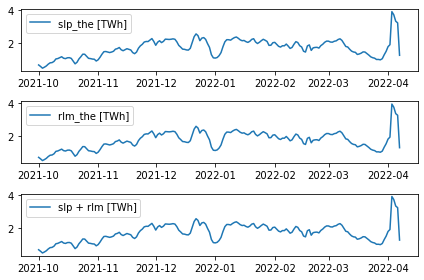

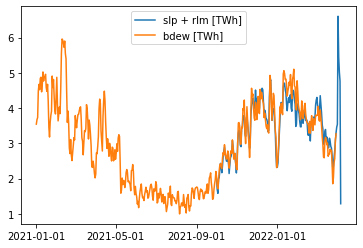

In [7]:
fig, axs = plt.subplots(3)

df_list = [the_slp, the_rlm, the_sum]

for i, df in enumerate(df_list):
    axs[i].plot(df.index, the_slp.iloc[:,0], label=df.columns[0])
    axs[i].legend()
    plt.tight_layout()

ax = the_sum.plot()
bdew.plot(ax=ax)
ax.set_xticks(ax.get_xticks()[::2])

plt.show()

In [8]:
common_date = the_sum.iloc[0].name
bdew_sum = bdew.loc[bdew.index>common_date].sum()[0]
the_sum_sum = the_sum.loc[the_sum.index>common_date].sum()[0]

print("Energy consumption since: {}".format(common_date.strftime("%Y-%m-%d")) + "\n" +
      "the [TWh]: "+ str(the_sum_sum) + "\n" +
      "bdew [TWh]: "+ str(bdew_sum) + "\n" +
      "delta [%]: " + str(100 * (the_sum_sum - bdew_sum )/ 
                    the_sum_sum)
                        ) 

Energy consumption since: 2021-10-01
the [TWh]: 660.629381757
bdew [TWh]: 636.8479555270001
delta [%]: 3.599813584850138


## Gas for electricity generation

In [9]:
power = pd.read_csv(os.path.join(data_path, "entsoe_2020_gas.csv"), index_col=0)
power_gas = power["scaled_to_AGEBL_2020 [TWh_gas/day]"].to_frame()
power_gas.index = pd.to_datetime(power_gas.index, utc = True).date

<AxesSubplot:>

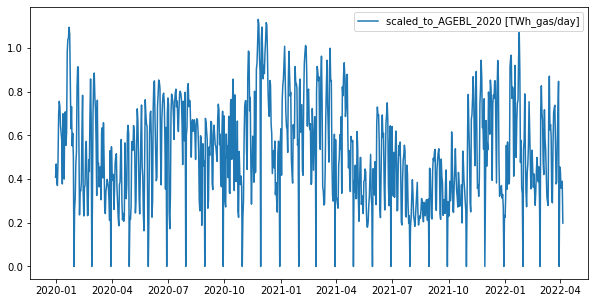

In [10]:
power_gas.plot(figsize=(10,5))

## Gas for electricity generation

In [11]:
gas_prices = pd.read_excel(os.path.join(data_path, "gas_prices_TTF.xlsx"), index_col=0)
gas_prices = gas_prices["Erdgas Spot TTF (lhs)"].to_frame().rename(columns={
    "Erdgas Spot TTF (lhs)":"gas_price [$/lhs]"}).dropna()
gas_prices.index = pd.to_datetime(gas_prices.index, utc = True).date

<AxesSubplot:>

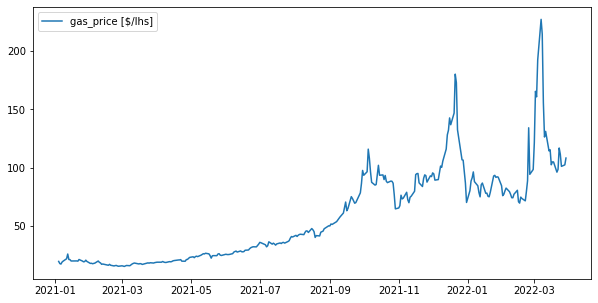

In [12]:
gas_prices.plot(figsize=(10,5))

# Analysis & plotting

## Align indexes
All calculations and plots are done for the same period: 01.10.2021-25.03.2022

In [13]:
first = the.iloc[0].name
last = estimated.iloc[-1].name

def unify_index(df):
    return df.loc[(df.index >= first) & (df.index <= last)]

In [14]:
estimated_new = unify_index(estimated)
the_slp_new = unify_index(the_slp)
the_rlm_new = unify_index(the_rlm)
the_sum_new = unify_index(the_sum)
bdew_new = unify_index(bdew)
power_gas_new = unify_index(power_gas)
gas_prices_new = unify_index(gas_prices)


#check if reindexing goes without problems:
estimated_new = estimated_new.reindex(index=the_sum_new.index)

# Subtract gas for electricity generation

### Substact gas for electricity generation 

In [48]:
bdew_res = bdew_new.subtract(power_gas_new.iloc[:, 0], axis = 0).rename(columns = {
    "bdew [TWh]": "bdew_res"})

In [51]:
the_rlm_res = the_rlm_new.subtract(power_gas_new.iloc[:, 0], axis = 0).rename(columns = {
    "rlm_the [TWh]": "rlm_the_res"})
the_sum_res = the_sum_new.subtract(power_gas_new.iloc[:, 0], axis = 0).rename(columns = {
    "slp + rlm [TWh]": "slp_sum_res"})

## THE vs. our estimates

In [17]:
y1=estimated_new["aggregated(no_dist_heat)"].to_frame("estimated_slp")
y2=the_slp_new
y3 = the_rlm_res

### Weekly analyis: Russian invasion: 24.02. (Thu), Fasching: 28.02.-02.03. (Mon-Wed)

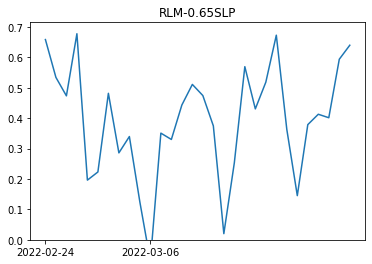

In [18]:
x = y3.loc[y3.index > pd.to_datetime("2022-02-23", utc = True).date()].index
y = (y3.iloc[:,0] - 0.5*y1.iloc[:,0]).loc[y3.index > pd.to_datetime("2022-02-23", utc = True).date()]

plt.plot(x, y) 

plt.ylim(0,)
plt.title("RLM-0.65SLP")
plt.xticks(ticks =x[:-10:10])

plt.show()

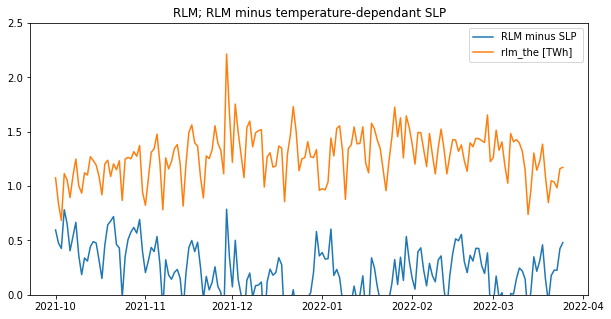

In [19]:
ax = (y3.iloc[:,0] - 0.65*y1.iloc[:,0]).to_frame().rename(columns={0:"RLM minus SLP "}).plot()
ax.set_ylim(0,2.5)
y3.plot(
    ax=ax, title = "RLM; RLM minus temperature-dependant SLP", figsize=(10,5))
plt.show()

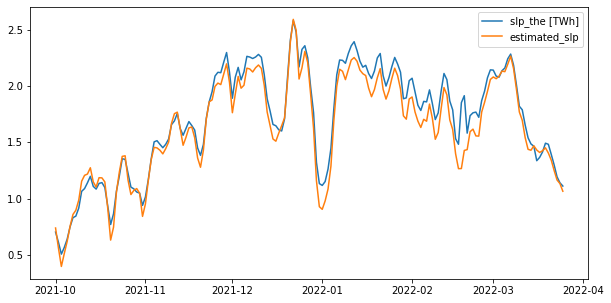

In [20]:
ax = y2.plot()
y1.plot(ax=ax, figsize=(10,5))

plt.show()

## THE vs. BDEW

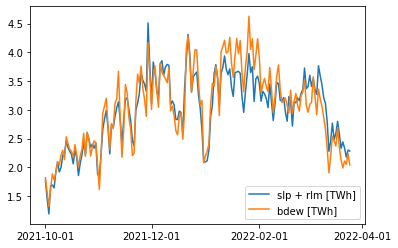

In [21]:
ax = the_sum_res.plot()
bdew_res.plot(ax=ax)
ax.set_xticks(ax.get_xticks()[::2])

plt.show()

In [22]:
bdew_sum = bdew_new.sum()[0]
the_sum_sum = the_sum_new.sum()[0]

print("Energy consumption between: {} and {}".format(first.strftime("%Y-%m-%d"), 
                                                    first.strftime("%Y-%m-%d")) + "\n" +
      "the [TWh]: "+ str(the_sum_sum) + "\n" +
      "bdew [TWh]: "+ str(bdew_sum) + "\n" +
      "delta [%]: " + str(100 * (the_sum_sum - bdew_sum )/ 
                    the_sum_sum)
                        ) 

Energy consumption between: 2021-10-01 and 2021-10-01
the [TWh]: 616.084159215
bdew [TWh]: 623.621056844
delta [%]: -1.2233552050101966


# Export

In [52]:
df_all = pd.concat([estimated_new[["aggregated(no_dist_heat)", "dist_heat"]], the_slp_new, the_rlm_new, the_rlm_res, bdew_new, bdew_res, power_gas_new, gas_prices_new], 
                  axis = 1)

In [53]:
df_all[["aggregated(no_dist_heat)", "slp_the [TWh]"]]#.fillna(0)

,aggregated(no_dist_heat),slp_the [TWh]
2021-10-01,0.738166,0.701800
2021-10-02,0.559080,0.610800
2021-10-03,0.396701,0.506066
2021-10-04,0.510587,0.565016
2021-10-05,0.618396,0.638871
...,...,...
2022-03-21,1.340926,1.392374
2022-03-22,1.248650,1.298474
2022-03-23,1.164591,1.192761
2022-03-24,1.132335,1.139399


In [54]:
df_all#.to_csv(os.path.join(data_path, "preprocessed.csv"))

,aggregated(no_dist_heat),dist_heat,slp_the [TWh],rlm_the [TWh],rlm_the_res,bdew [TWh],bdew_res,scaled_to_AGEBL_2020 [TWh_gas/day],gas_price [$/lhs]
2021-10-01,0.738166,0.037952,0.701800,1.304783,1.075785,2.046847,1.817849,0.228998,93.620
2021-10-02,0.559080,0.028744,0.610800,1.077491,0.839662,1.802717,1.564888,0.237829,NaN
2021-10-03,0.396701,0.020396,0.506066,1.074001,0.683518,1.707964,1.317480,0.390484,NaN
2021-10-04,0.510587,0.026251,0.565016,1.415380,1.114668,1.932167,1.631455,0.300713,96.650
2021-10-05,0.618396,0.031794,0.638871,1.393310,1.053295,2.226157,1.886142,0.340015,116.020
...,...,...,...,...,...,...,...,...,...
2022-03-21,1.340926,0.068942,1.392374,1.752227,1.049493,2.692656,1.989922,0.702734,96.302
2022-03-22,1.248650,0.064197,1.298474,1.763850,1.037472,2.834050,2.107672,0.726378,98.745
2022-03-23,1.164591,0.059876,1.192761,1.722181,0.984015,2.790061,2.051894,0.738166,117.000
2022-03-24,1.132335,0.058217,1.139399,1.723889,1.160395,2.802156,2.238661,0.563494,111.610


In [55]:
df = df_all

In [56]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [57]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [58]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [59]:
df

,aggregated(no_dist_heat),dist_heat,slp_the [TWh],rlm_the [TWh],rlm_the_res,bdew [TWh],bdew_res,scaled_to_AGEBL_2020 [TWh_gas/day],gas_price [$/lhs],index,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2021-10-01,0.738166,0.037952,0.701800,1.304783,1.075785,2.046847,1.817849,0.228998,93.620,2021-10-01,...,2021,10,Friday,4,0,1,0,0,0,0
2021-10-02,0.559080,0.028744,0.610800,1.077491,0.839662,1.802717,1.564888,0.237829,NaN,2021-10-02,...,2021,10,Saturday,5,0,0,1,0,0,0
2021-10-03,0.396701,0.020396,0.506066,1.074001,0.683518,1.707964,1.317480,0.390484,NaN,2021-10-03,...,2021,10,Sunday,6,0,0,1,0,1,0
2021-10-04,0.510587,0.026251,0.565016,1.415380,1.114668,1.932167,1.631455,0.300713,96.650,2021-10-04,...,2021,10,Monday,0,1,0,0,0,0,0
2021-10-05,0.618396,0.031794,0.638871,1.393310,1.053295,2.226157,1.886142,0.340015,116.020,2021-10-05,...,2021,10,Tuesday,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,1.340926,0.068942,1.392374,1.752227,1.049493,2.692656,1.989922,0.702734,96.302,2022-03-21,...,2022,3,Monday,0,1,0,0,0,0,0
2022-03-22,1.248650,0.064197,1.298474,1.763850,1.037472,2.834050,2.107672,0.726378,98.745,2022-03-22,...,2022,3,Tuesday,1,0,0,0,0,0,0
2022-03-23,1.164591,0.059876,1.192761,1.722181,0.984015,2.790061,2.051894,0.738166,117.000,2022-03-23,...,2022,3,Wednesday,2,0,0,0,0,0,0
2022-03-24,1.132335,0.058217,1.139399,1.723889,1.160395,2.802156,2.238661,0.563494,111.610,2022-03-24,...,2022,3,Thursday,3,0,0,0,0,0,0


In [60]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))

df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df['cet_cest_timestamp'].apply(lambda x: x[:4])
df['month'] = df['cet_cest_timestamp'].apply(lambda x: x[5:7])

df['weekday'] = df['cet_cest_timestamp'].apply(lambda x: pd.Timestamp(x).day_name())
df['weekday_num'] = df['cet_cest_timestamp'].apply(lambda x: pd.Timestamp(x).weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

df['christmas_period'] = df['cet_cest_timestamp'].apply(
    lambda x: int((pd.Timestamp(x).month==12)&(pd.Timestamp(x).day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['cet_cest_timestamp'].apply(lambda x: int(pd.Timestamp(x) in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)